In [16]:
import sys
import seaborn as sns
import os
import glob
from matplotlib import pyplot as plt
import numpy as np
import plot as pltfn
from sklearn.cluster import KMeans
import admin_functions as adfn
import networkx as nx
import network as netfn
#plt.style.use('dark_background')
sns.reset_orig()
%load_ext autoreload
%autoreload

sns.reset_orig()
plt.style.use('dark_background')


# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'
experiment = 'PTZ-WILDTYPE'
savepath = Fdrop + 'Project/' + experiment + os.sep 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collectio

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
node = sorted(glob.glob('knodes*'))
cyclist = sorted(glob.glob('netparam2*-cycles*'))

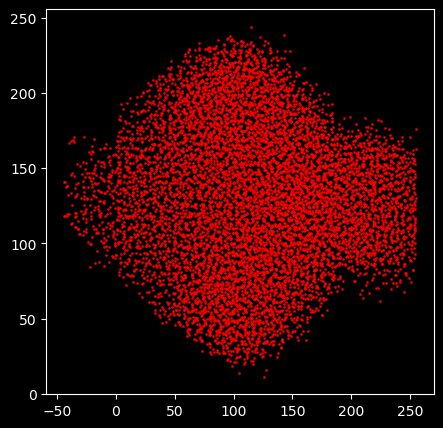

In [14]:
fig,axarr = plt.subplots(figsize = (5,5))
nodes = np.load(node[0])
axarr.scatter(nodes[:,0], nodes[:,1], s = 1, color = 'red' , alpha = 0.8)
plt.show()

In [18]:
#K + P - LOG SCALE 
import numpy as np
import matplotlib.pyplot as plt
p_vals = adfn.repeat_list(0.1, 5)
k_vals = [0.001, 0.05]

cell_locs = nodes
dist = euclidean_distances(nodes)


In [19]:
p_vals

[0.1, 0.1, 0.1, 0.1, 0.1]

In [20]:
k_vals

[0.001, 0.05]

In [21]:
savepath = Fdrop + 'Project/' + experiment + os.sep 

# Sweep through k and p
#----------------------------------------
from scipy import sparse
import scipy
import networkx as nx
for i in range(len(k_vals)):
    for e in range(len(p_vals)):
        output = netfn.netsim(dist).ws_generate(k_vals[i], p_vals[e])
        sparse_A = sparse.csr_matrix(output.A)
        scipy.sparse.save_npz(savepath + 'network2-k' + str(k_vals[i]) + '-p' + str(p_vals[e]) + '-' + str(e+1), sparse_A)
        mat = output.A
        G = nx.from_numpy_matrix(mat)
        cyc = nx.algorithms.cycle_basis(G)
        edge =  G.number_of_edges() 
        cyc_vec = np.zeros(len(cyc))
        for t in range(len(cyc)):
            cyc_vec[t] = len(cyc[t])
        cyc_list = [np.unique(cyc_vec, return_counts=True),len(cyc),edge]
        np.save(savepath + 'network2-k-' +  str(k_vals[i]) + '-p' + str(p_vals[e]) + '-' + str(e+1) + '-cycles.npy', cyc_list)
        print('Done #' + str(e) + 'of' + str(k_vals[i]))

Done #0of0.001
Done #1of0.001
Done #2of0.001
Done #3of0.001
Done #4of0.001
Done #0of0.05
Done #1of0.05
Done #2of0.05
Done #3of0.05
Done #4of0.05
